# Importing libraries

In [1]:
from diff_weighted_fields import Grid1D, Field1D, PowerSpectrum, GaussianFieldGenerator1D, Zeldovich1D
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax

In [2]:
def PK(k,theta, threshold = 0.001):
    A,R,n = theta
    _p = A*(k*R)**n*jnp.exp(-(k*R)**2)
    sig = jnp.max(_p)
    return _p + sig* threshold

# Gaussian Fields

In [85]:
L = 100 #box size
N = 1024 #mesh size

There are two ways to control the resolution of the simulations: clipping and smoothing via gaussian. The argument are always in units of the cellsize

In [ ]:
R_clip = 1
R_gauss = 2

dk = 10
kmax = 1
kmin = 10

grid_gauss = Grid1D((N,), L, R_gauss = R_gauss,dk =dk, kmax =kmax,kmin =kmin)
grid_clip = Grid1D((N,), L, R_clip = R_clip,dk =dk, kmax =kmax,kmin =kmin)
grid_bare = Grid1D((N,), L, dk = dk, kmax =kmax,kmin =kmin)
k_abs = grid_gauss.kgrid_abs
k_ctrs = grid_gauss.k_ctrs

plt.figure(figsize =(4,4))
plt.plot(k_abs, grid_gauss.GRID_SMOOTHING_KERNEL)
plt.plot(k_abs, grid_clip.GRID_SMOOTHING_KERNEL)
plt.plot(k_abs, grid_bare.GRID_SMOOTHING_KERNEL)

In [31]:
gen_gauss = GaussianFieldGenerator1D(grid_gauss, PK)
gen_clip = GaussianFieldGenerator1D(grid_clip, PK)
gen_bare = GaussianFieldGenerator1D(grid_bare, PK)

A =2.
R = 2*grid_gauss.H[0]
n = 2

theta = jnp.array([A,R,n])
keys = PRNGKey(2)
noise = grid_gauss.generate_hermitian_noise(keys)

In [ ]:
plt.figure()
plt.plot(k_ctrs, PK(k_ctrs, theta))

In [33]:
field_gauss = gen_gauss.make_realization_from_noise(theta,noise)
field_gauss.compute_ifft()

field_clip =gen_clip.make_realization_from_noise(theta,noise)
field_clip.compute_ifft()

field_bare =gen_bare.make_realization_from_noise(theta,noise)
field_bare.compute_ifft()

In [34]:
def _pk(A,R,n,gen_gauss,noise):
    field = gen_gauss.make_realization_from_noise(jnp.array([A,R,n]),noise)
    pk = PowerSpectrum(field,field)
    return pk


keys = split(PRNGKey(2),100)
noise = jnp.array([grid_gauss.generate_hermitian_noise(x) for x in keys])
pk = lambda A,R,n,gen: jnp.mean(jax.vmap(_pk,in_axes=(None,None,None,None,0))(A,R,n,gen,noise),axis = 0)

In [ ]:
plt.figure(figsize = (5,2),dpi = 120)
plt.plot(field_bare.delta, label ='bare',lw = '2', color = 'black', alpha = 0.2)
plt.plot(field_gauss.delta, label ='gaussian')
plt.plot(field_clip.delta, label ='clipping')
plt.xlim((0,100))
plt.legend(ncols = 3)
plt.xlabel('x [Mpc]')

plt.figure()
plt.loglog(k_ctrs, pk(A,R,n,gen_gauss), label = 'gaussian')
plt.loglog(k_ctrs, pk(A,R,n,gen_clip), label = 'clip')
plt.loglog(k_ctrs, pk(A,R,n,gen_bare), label = 'bare')
plt.loglog(k_ctrs, PK(k_ctrs,theta),label = 'input', ls = '--')
plt.legend()
plt.ylim((1e-7,1e1))

# Zeldovich maps

In [ ]:
L = 4000
N = 2048
dk = 6
kmin = 2
R_clip = 4
kmax = 0.5
#define the field and gaussian generator
grid = Grid1D((N,), L, R_clip = R_clip, dk =dk, kmax = kmax , kmin =kmin)
gen = GaussianFieldGenerator1D(grid, PK)
grid_mesh = Grid1D((N//2,), L, R_clip = 0,dk =dk, kmax = 0.5, kmin =kmin)

In [4]:
A = 2.
R = 4*grid.H[0]
n = 2

theta = jnp.array([A,R,n])
keys = PRNGKey(2)
noise = grid.generate_hermitian_noise(keys)

#generate one gaussian realization
gauss = gen.make_realization_from_noise(theta, noise)
gauss.compute_ifft()

#generate the zeldovich generator
zel_cic = Zeldovich1D(gen, grid_mesh, scheme = 'cic')
zel_tsc = Zeldovich1D(gen, grid_mesh,scheme = 'tsc')

In [ ]:
D = 0.1
zel_cic.make_realization(D,theta,noise)

plt.figure()
plt.plot(zel_cic.grid.q,zel_cic.delta/D, label = 'zel tsc')
plt.plot(gauss.grid.q,gauss.delta, label = 'gauss')

plt.xlim((-1,200))
plt.ylim((-1,2))
plt.legend()

In [8]:
keys = split(PRNGKey(2),500)
NOISE = jnp.array([grid.generate_hermitian_noise(x) for x in keys])
k_ctrs = grid_mesh.k_ctrs

In [9]:
def _pk_zel(D,theta,noise):
    zel_cic.make_realization(D,theta,noise)
    pk = PowerSpectrum(zel_cic,zel_cic,compensate=True)
    return pk

pk_zel = lambda D,theta: jnp.mean(jax.vmap(_pk_zel, in_axes=(None,None,0))(D,theta,NOISE),axis = 0)

In [ ]:
plt.figure()
for d in [0.2,0.5,1,2,3]:
    plt.plot(k_ctrs,pk_zel(d,theta)/d**2, label = f'D={d}')
plt.plot(k_ctrs,PK(k_ctrs,theta), color = 'black', ls = '--', label = 'input')
plt.legend()
plt.xlabel('k [1/Mpc]')
plt.ylabel('P(k)')

In [ ]:
def _pk_zel(D,R,noise):
    zel_cic.make_realization(D,jnp.array([A,R,n]),noise)
    return jnp.abs(zel_cic.delta)**2

_pk_zel(2.,5.,NOISE[9])
jax.jacrev(_pk_zel,argnums=1)(1.,1.,NOISE[2])

In [43]:
def _pk_zel(D,R,noise):
    zel_cic.make_realization(D,jnp.array([A,R,n]),noise)
    pk = PowerSpectrum(zel_cic,zel_cic,compensate=False)
    return pk

pk_zel = lambda D,R: jnp.mean(jax.vmap(_pk_zel, in_axes=(None,None,0))(D,R,NOISE),axis = 0)
dP_dR = jax.jacrev(pk_zel, argnums=1)

# Derivatives

In [ ]:
L = 4000
N = 2024
dk = 6
kmin = 5
R_clip = 3
kmax = 0.6

#define the field and gaussian generator
grid = Grid1D((N,), L, R_clip = R_clip, dk =dk, kmax = kmax , kmin =kmin)
gen = GaussianFieldGenerator1D(grid, PK)

In [ ]:
mesh = Grid1D((N//2,), L, R_clip = 0, dk =dk, kmax = kmax , kmin =kmin)

In [9]:
A = 2.
R = 2*grid.H[0]
n = 2.

keys = split(PRNGKey(2),100)
noise = jnp.array([grid.generate_hermitian_noise(x) for x in keys])

#generate the zeldovich generator
zel = Zeldovich1D(gen,mesh, scheme = 'tsc')

In [10]:
field = zel.make_realization(2, jnp.array([A,R,n]), noise[0])

In [11]:
zel.ComputeBasis(R)

In [12]:
m_array = zel.m_array
C = jnp.array([1,1,0,0])

In [ ]:
zel.WeightedChild(C)

In [14]:
def foo(A,R,n,noise):
    zel.make_realization(3, jnp.array([A,R,n]), noise)
    pk = PowerSpectrum(zel, zel, compensate=True)
    return pk

foo_avg = lambda A, R, n: jnp.mean(jax.vmap(lambda noise: foo(A, R, n, noise))(noise), axis=0)
dP_dR = jax.jacrev(foo_avg, argnums=1)
dP_dA = jax.jacrev(foo_avg, argnums=0)
dP_dn = jax.jacrev(foo_avg, argnums=2)

In [ ]:
plt.plot(foo_avg(A,R,n))
plt.plot(dP_dR(A,R,n))
plt.plot(dP_dA(A,R,n))
plt.plot(dP_dn(A,R,n))

# Weighted

In [3]:
L = 4000
N = 2024
dk = 6
kmin = 5
R_clip = 3
kmax = 0.6

#define the field and gaussian generator
grid = Grid1D((N,), L, R_clip = R_clip, dk =dk, kmax = kmax , kmin =kmin)
mesh = Grid1D((N//2,), L, R_clip = 0, dk =dk, kmax = kmax , kmin =kmin)
gen = GaussianFieldGenerator1D(grid, PK)
zel = Zeldovich1D(gen, mesh, scheme = 'cic')

keys = split(PRNGKey(2),100)
noise = jnp.array([grid.generate_hermitian_noise(x) for x in keys])

#fid params
A = 2.
R = 4*grid.H[0]
n = 2.

Using clipping smoothing with R_clip = 3 cells (physical = 5.928853988647461); k_clip = 1.060e+00
kmin: 0.007853981633974483
kmax: 0.9537875652313232
dk: 0.00942477796076938
kmin: 0.007853981633974483
kmax: 0.4768937826156616
dk: 0.00942477796076938


In [4]:
zel.make_realization(1.2, jnp.array([A,R,n]), noise[0])
zel.ComputeBasis(grid.H*2)
C = jnp.array([1,-2,0,0])
f = zel.WeightedChild(C)

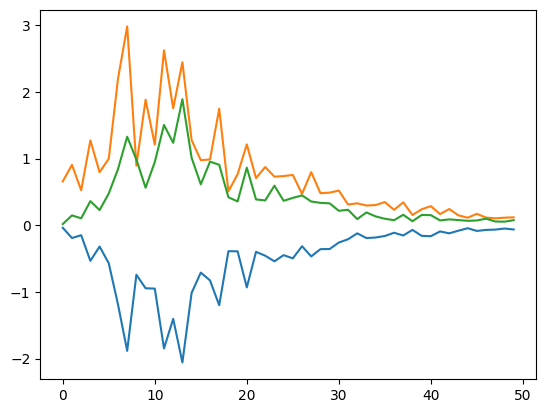

In [5]:
pk1 = PowerSpectrum(f,zel,compensate=True)
pk2 = PowerSpectrum(f,f,compensate=True)
pk3 = PowerSpectrum(zel,zel,compensate=True)

plt.figure()
plt.plot(pk1, label='weighted child')
plt.plot(pk2, label='weighted child')
plt.plot(pk3, label='weighted child')

In [34]:
def foo(A,R,n,C,noise):
    zel.make_realization(2, jnp.array([A,R,n]), noise)
    zel.ComputeBasis(R*2)
    f = zel.WeightedChild(C)
    pk = PowerSpectrum(f, f, compensate=True)
    return pk

foo_avg = lambda A, R, n, C: jnp.mean(jax.vmap(lambda noise: foo(A, R, n, C, noise))(noise), axis=0)
dP_dR = jax.jacrev(foo_avg, argnums=1)
dP_dA = jax.jacrev(foo_avg, argnums=0)
dP_dn = jax.jacrev(foo_avg, argnums=2)

In [35]:
%%timeit -n 2 -r 10
dP_dR_jit(A,R,n,C)

The slowest run took 22.02 times longer than the fastest. This could mean that an intermediate result is being cached.
348 μs ± 341 μs per loop (mean ± std. dev. of 10 runs, 2 loops each)


In [15]:
foo_jit = jax.jit(foo)

In [16]:
foo_jit(A,R,n,C,noise[0])

Array([0.32736745, 0.6050904 , 0.27146488, 0.8071479 , 0.3099147 ,
       0.20952976, 0.3289453 , 0.1639909 , 0.4653226 , 0.21647352,
       0.7686102 , 1.545024  , 1.487605  , 2.858042  , 1.7810856 ,
       1.2479379 , 1.8320366 , 1.3593011 , 0.7837358 , 0.7876276 ,
       1.608687  , 0.62832487, 0.53426   , 1.9182532 , 0.56497073,
       0.8621057 , 1.1867564 , 1.0641898 , 0.9361279 , 0.38701165,
       0.47534674, 0.9729572 , 0.16610514, 0.5806442 , 0.34222838,
       0.5171875 , 0.5274212 , 0.7510668 , 0.5503286 , 0.5577915 ,
       0.47377184, 0.1811192 , 0.26888552, 0.12758368, 0.30147514,
       0.29154828, 0.61678934, 0.25009233, 0.14801368, 0.6225637 ],      dtype=float32)

In [58]:
C = jnp.array([-0.5,3,0,0])  # Example coefficients for the weighted child
pk = foo_avg(A,R,n,C)
dR = dP_dR(A,R,n,C)
dA = dP_dA(A,R,n,C)
dn = dP_dn(A,R,n,C)

In [ ]:
plt.plot(dA)
plt.plot(dn)
plt.plot(dR)